In [140]:
import rasterio
import pprint
import fiona
import matplotlib.pyplot as plt
import numpy as np
from descartes import PolygonPatch
from fiona import collection
import geopandas as gpd
from rasterio import features
from rasterio import mask
import json
import earthpy as et 
import earthpy.plot as ep
import earthpy.spatial as es
import cartopy as cp
from rasterio.plot import show
from shapely.geometry import mapping
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

from mpl_toolkits.axes_grid1 import make_axes_locatable


In [11]:
dataset = rasterio.open('nsrdbv3_dni/Monthly DNI/dni_aug.tif')

In [22]:
band1 = dataset.read(1)
band = dataset.read(masked=True)[0]

In [28]:
band1.shape
print(np.max(band1))
print(np.min(band1))
extent = rasterio.plot.plotting_extent(dataset)
print(dataset.profile)

446.0972340124505
-9999.0
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 3940, 'height': 2025, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.04, 0.0, -180.0,
       0.0, -0.04, 59.99), 'tiled': False, 'interleave': 'band'}


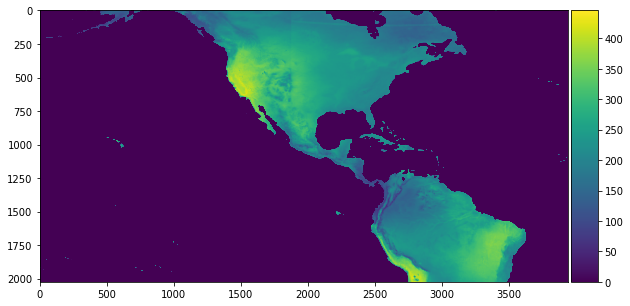

In [116]:
def imshow_colorbar(data, vmin=None, vmax=None):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    im = ax.imshow(data, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
imshow_colorbar(band1, vmin=0)

In [185]:
def calc_mean_insol_area(data, mask):
    invmask = ~mask
    return np.mean(data[invmask])

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


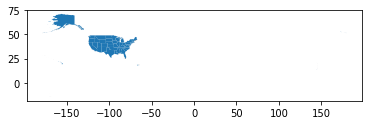

In [195]:
shapefile = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
print(shapefile.keys())
shapefile.plot()
shapefile.head()

In [190]:
def get_region_insol_data(dataset, shapefile):
    areas = {}
    for index in range(5):
        if shapefile.geometry[index].type == 'Polygon':
            region = MultiPolygon([shapefile.geometry[index]])
        else:
            region = shapefile.geometry[index]
        cropd, crop_meta = es.crop_image(dataset, region)
        cropd_ma = np.ma.masked_equal(cropd[0], -9999.0)
        areas[index] = { \
            "Name": shapefile.NAME[index], \
            "Abbrev": shapefile.STUSPS[index], \
            "Data": cropd_ma, \
            "Meta": crop_meta, \
            "insol": calc_mean_insol_area(cropd_ma.data, cropd_ma.mask)}
    return areas

207.4637453264569


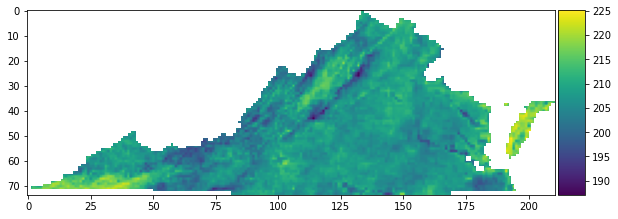

In [192]:
states = get_region_insol_data(dataset=dataset, shapefile=shapefile)
imshow_colorbar(states[3]["Data"])
print(states[3]["insol"])

In [ ]:
MS = shapefile.geometry[0]
cropd, crop_meta = es.crop_image(dataset, MS)
cropd_ma = np.ma.masked_equal(cropd[0], -9999.0)
ep.plot_bands(cropd_ma)

In [108]:
statedict = { \
         "Mississippi": { \
                        "Data": cropd_ma, \
                        "Meta": crop_meta}}
statedict2 = { \
         "Mississippi2": { \
                        "Data": cropd_ma, \
                        "Meta": crop_meta}}

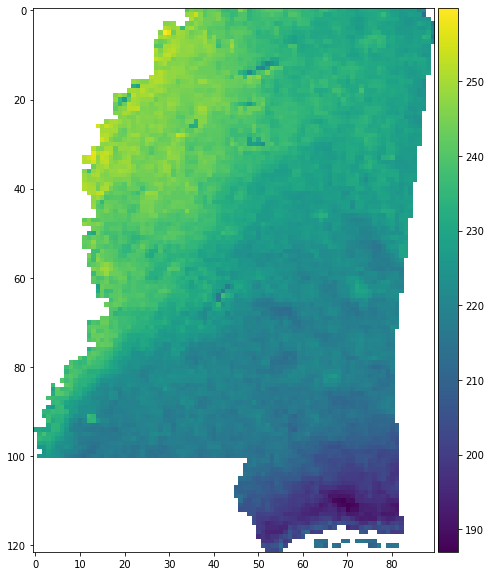

In [112]:
imshow_colorbar(states["Mississippi"]["Data"])

AxesSubplot(0.170041,0.406466;0.657977x0.192068)


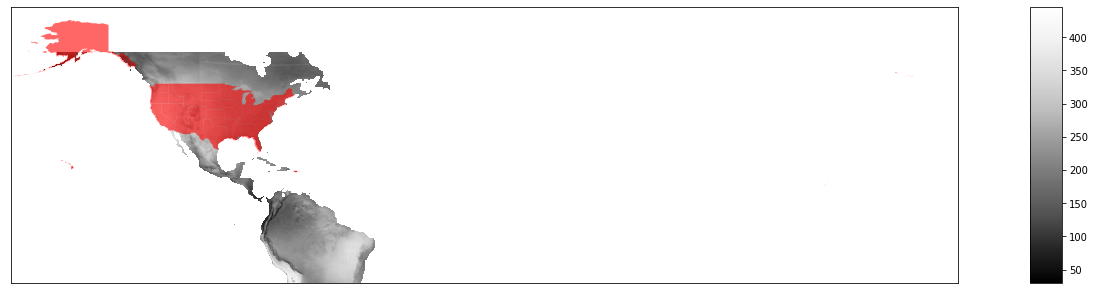

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))
ep.plot_bands(band, extent=extent, ax=ax)
shapefile.plot(ax=ax, alpha = .6, color='r')
print(ax)